Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [1]:
from socket import gethostname
gethostname()

'hpc3-gpu-23-01'

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.output_layer = nn.Linear(64*12*12, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 64*12*12)
        x = self.output_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc.append(correct / total)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}')


Using device: cuda


Epoch 1/10:   0%|                                                                                                                 | 0/898 [00:00<?, ?it/s]/data/homezvol0/gaog5/.conda/envs/copilot/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403463728/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:02<00:00, 14.43it/s]


Epoch 1, Train Loss: 1.579214250166516, Val Loss: 1.4170048305104124, Train Acc: 0.3826674561984047, Val Acc: 0.45723042630259125


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:00<00:00, 14.92it/s]


Epoch 2, Train Loss: 1.3542356148272365, Val Loss: 1.3254356421644424, Train Acc: 0.48772162039778466, Val Acc: 0.4941487879632209


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:00<00:00, 14.76it/s]


Epoch 3, Train Loss: 1.2477112248996163, Val Loss: 1.3198373405406587, Train Acc: 0.5314361350099271, Val Acc: 0.5013931457230426


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:59<00:00, 15.01it/s]


Epoch 4, Train Loss: 1.1662491971852076, Val Loss: 1.2989776845794097, Train Acc: 0.566825734090355, Val Acc: 0.515881861242686


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:02<00:00, 14.40it/s]


Epoch 5, Train Loss: 1.098584489732033, Val Loss: 1.296090025927038, Train Acc: 0.5945522310076979, Val Acc: 0.5267483978824185


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:03<00:00, 14.06it/s]


Epoch 6, Train Loss: 1.0441111020606042, Val Loss: 1.302820343265762, Train Acc: 0.616287575324811, Val Acc: 0.5268877124547228


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:06<00:00, 13.41it/s]


Epoch 7, Train Loss: 0.9942355667968841, Val Loss: 1.322833325511468, Train Acc: 0.6335295551917517, Val Acc: 0.5241014210086375


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [01:02<00:00, 14.33it/s]


Epoch 8, Train Loss: 0.953361518470059, Val Loss: 1.3363954972244299, Train Acc: 0.6482636107144101, Val Acc: 0.5271663415993313


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:59<00:00, 15.05it/s]


Epoch 9, Train Loss: 0.9108332455596304, Val Loss: 1.3528052025367436, Train Acc: 0.6681180117733115, Val Acc: 0.5254945667316802


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:58<00:00, 15.24it/s]


Epoch 10, Train Loss: 0.8759484338932283, Val Loss: 1.4247909993904817, Train Acc: 0.6784631996934759, Val Acc: 0.5181108943995542


In [4]:
print(model)

FERModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Linear(in_features=9216, out_features=7, bias=True)
)


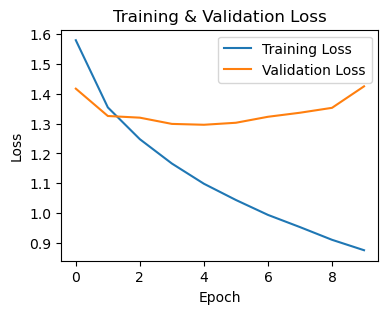

In [5]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [6]:
print(train_losses)
print(val_losses)

[1.579214250166516, 1.3542356148272365, 1.2477112248996163, 1.1662491971852076, 1.098584489732033, 1.0441111020606042, 0.9942355667968841, 0.953361518470059, 0.9108332455596304, 0.8759484338932283]
[1.4170048305104124, 1.3254356421644424, 1.3198373405406587, 1.2989776845794097, 1.296090025927038, 1.302820343265762, 1.322833325511468, 1.3363954972244299, 1.3528052025367436, 1.4247909993904817]


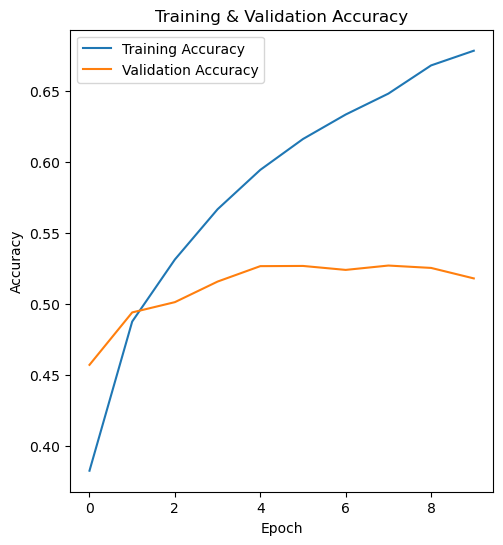

In [7]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.5181
F1 Score: 0.5220


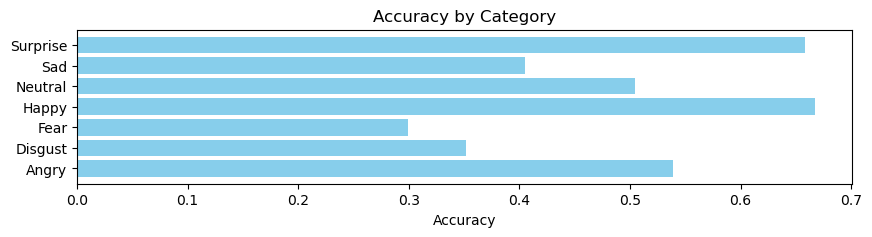

In [9]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
categories = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(categories)
ax.set_title('Accuracy by Category')
plt.show()

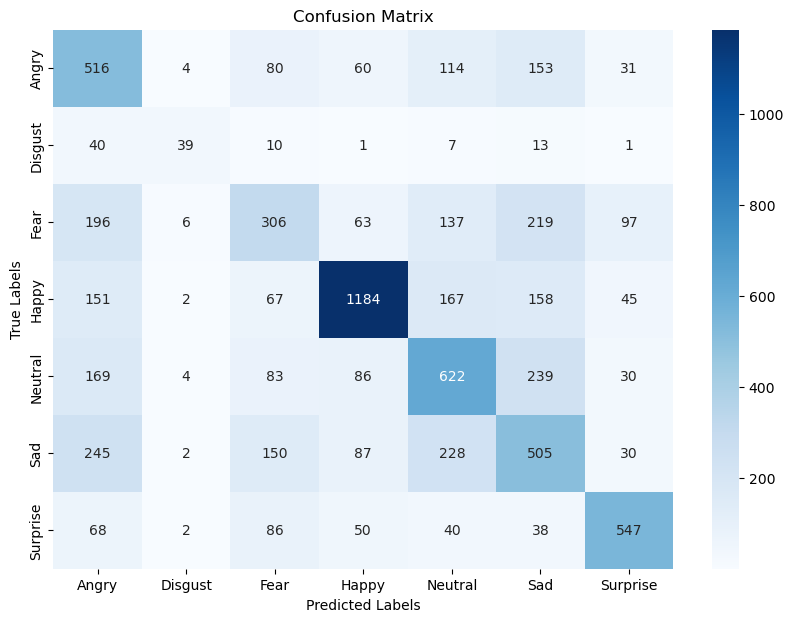

In [10]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
